This code is designed to compute the Canonical Correspondance Analysis (CCA) in Python via the R package Vegan and calling R via Python Package rpy2. This is requires R to be accessible from the Python envirnoment where the code is running. In this code it is done via Conda however there are alternative setups if your computer has a different setup. 

In [1]:


#Import all the neccessary packages
import os
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
import rpy2.robjects.pandas2ri
from sklearn.model_selection import train_test_split # Keeping import for flexibility
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc


# Get the current conda environment path
conda_env_path = os.environ.get('CONDA_PREFIX')
#Setup the paths for 
if conda_env_path:
    os.environ['R_HOME'] = os.path.join(conda_env_path, 'lib', 'R')
    print(f"Setting R_HOME for Conda environment: {os.environ['R_HOME']}")


#Activate the vegan package
#This will error if you don't have R in the correct environment setup
rpy2.robjects.numpy2ri.activate()
vegan = importr('vegan')
print("vegan loaded successfully!")


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr

# Activate rpy2 for conversion of numpy and pandas 
numpy2ri.activate()
pandas2ri.activate()

# Load R packages which may be required

base = importr('base')
stats = importr('stats')
utils = importr('utils')
grDevices = importr('grDevices')

# Enable LaTeX rendering for all text in Matplotlib
#Disable this if there is no LaTex installed 
rc('text', usetex=True)

#You can also select the font  
rc('font', family='serif')


Setting R_HOME for Conda environment: /opt/miniconda3/envs/ML-pytorch/lib/R
vegan loaded successfully!


The below cell contains a function which will perform CCA on a set of features X and species data y both given as pandas dataframes and will plot the output as plot generated in R as well. In this code we also plot in python however this quick plot demonstates things are working. The function also gives the option to use the predict function in vegan on new environmental data given as Pandas dataframe and a series of predicted labels. We use the Vegan argument for plot_scaling =1

In [2]:





def perform_cca_and_plot(X, y, output_file="cca_biplot.pdf", scaling =1, new_env_data=None, predict_labels=None):
    """
    Performs Canonical Correspondence Analysis (CCA) using the vegan package in R,
    plots the ordination biplot, and saves to a file.
    

    Args:
        X: Features (e.g., environmental variables) as a Pandas DataFrame.
        y: Species data as a Pandas DataFrame.
        output_file (str): The filename (e.g., "cca_biplot.pdf" or "cca_biplot.png")
                           where the plot will be saved.
        scaling: 1,2,3 set the scaling expected by the Vegan package 
        new_env_data (Pandas DataFrame, optional): A DataFrame of unseen environmental
                                                   data for which to predict site scores.
                                                   Should have the same columns as X.
        predict_labels (list or pandas.Series, optional): A list or Series of labels
                                                          for the predicted new sites.
                                                          Its length must match the number
                                                          of rows in new_env_data.

    Returns:
        cca_result: The CCA result object from R.
        predicted_new_sites: Pandas DataFrame of predicted site scores for new_env_data, or None.
    """

    X_data = X
    y_data = y

    # Convert Python data to appropriate R types
    py_X_r = ro.conversion.py2rpy(X_data)

    # Get species names for plotting
    species_names_py = y_data.columns.tolist()
    species_names_r = ro.StrVector(species_names_py)

    py_y_r = ro.conversion.py2rpy(y_data)
    py_y_matrix = base.as_matrix(py_y_r)

    # Put R objects into R's global environment
    ro.globalenv['py_X_r'] = py_X_r
    ro.globalenv['py_y_matrix'] = py_y_matrix

    # Construct the CCA formula
    cca_formula_str = f'py_y_matrix ~ .'
    fmla = ro.Formula(cca_formula_str)

    # Perform CCA on the data
    plot_scaling = scaling
    
    cca_result = vegan.cca(fmla, data=py_X_r, scaling=plot_scaling)

    # Set up the plotting device (e.g., PDF)
    if output_file.lower().endswith('.pdf'):
        grDevices.pdf(output_file, width=15, height=10)
    elif output_file.lower().endswith('.png'):
        grDevices.png(output_file, width=800, height=800)
    else:
        print(f"Warning: Unsupported output format '{output_file}'. Saving as PDF.")
        grDevices.pdf(output_file + ".pdf", width=10, height=10)

    predicted_new_sites = None
    try:
        

        # Plot the ordination biplot
        ro.r.plot(cca_result, type="n", main="CCA Biplot", scaling=plot_scaling)

       

        # Add site scores (as points) from the original data
        site_names_py = X_data.index.astype(str).tolist()
        site_names_r = ro.StrVector(site_names_py)
        ro.r.points(cca_result, display="sites", col="black", pch=1, scaling=plot_scaling)


        # Add species scores (as text labels)
        ro.r.text(cca_result, display="species", labels=species_names_r,
                  cex=0.8, col="darkgreen", font=2, scaling=plot_scaling)

        eigenvalues = vegan.eigenvals(cca_result)
        #print("Eigenvalues:")
        #print(eigenvalues)

        # Add environmental variables (as arrows with labels)
        env_names_py = [str(col) for col in X_data.columns]
        env_names_r = ro.StrVector(env_names_py)
        ro.r.text(cca_result, display="bp", labels=env_names_r, col="blue", cex=0.9, scaling=plot_scaling)

        # --- Prediction for Unseen Environmental Data ---
        if new_env_data is not None:
            if not isinstance(new_env_data, pd.DataFrame):
                raise ValueError("new_env_data must be a Pandas DataFrame.")
            if not all(col in new_env_data.columns for col in X_data.columns):
                raise ValueError("new_env_data must contain all columns present in X.")
            if not all(col in X_data.columns for col in new_env_data.columns):
                print("Warning: new_env_data has extra columns not in X. Only common columns will be used for prediction.")
                new_env_data = new_env_data[X_data.columns]

            # Convert new_env_data to an R DataFrame
            py_new_env_r = ro.conversion.py2rpy(new_env_data)
            ro.globalenv['py_new_env_r'] = py_new_env_r

            # Predict site scores for the new data using type="lc"
            predicted_scores_r = base.as_data_frame(ro.r.predict(cca_result,
                                                                 newdata=py_new_env_r,
                                                                 type="lc",
                                                                 scaling=plot_scaling))
            predicted_new_sites = pandas2ri.rpy2py(predicted_scores_r)
            predicted_new_sites.index = new_env_data.index # Assign original index

            

            # Add predicted new site scores to the plot
            predicted_x = ro.FloatVector(predicted_new_sites.iloc[:, 0])
            predicted_y = ro.FloatVector(predicted_new_sites.iloc[:, 1])

            # Plot points first
            ro.r.points(predicted_x, predicted_y, col="red", pch=17, cex=1.2) # Use pch=17 for triangles

            # --- Add labels for predicted points ---
            if predict_labels is not None:
                if len(predict_labels) != len(new_env_data):
                    raise ValueError("Length of predict_labels must match the number of rows in new_env_data.")
                predicted_labels_r = ro.StrVector([str(label) for label in predict_labels])
                # Adjust position (pos=1 for below, pos=3 for above, pos=2 for left, pos=4 for right)
                ro.r.text(predicted_x, predicted_y, labels=predicted_labels_r,
                          col="red", cex=0.7, pos=3) # pos=3 places text above the point
            else:
                # If no explicit predict_labels, use the index from new_env_data as labels
                new_site_names_py = new_env_data.index.astype(str).tolist()
                new_site_names_r = ro.StrVector(new_site_names_py)
                ro.r.text(predicted_x, predicted_y, labels=new_site_names_r,
                          col="red", cex=0.7, pos=3)

            # Update legend to include new sites
            ro.r.legend("topleft",
                        legend=["Original Sites", "Species", "Environmental Variables", "New Unseen Sites"],
                        col=["black", "darkgreen", "blue", "red"],
                        pch=ro.IntVector([1, 3, 17, 17]), # Match pch values
                        cex=0.8,
                        bty="o",
                        pt_cex=1.5)
        else:
            # Original legend if no new_env_data is provided
            ro.r.legend("topright",
                        legend=["Sites", "Species", "Environmental Variables"],
                        col=["black", "darkgreen", "blue"],
                        pch=ro.IntVector([1, 3, 17]),
                        cex=0.8,
                        bty="o",
                        pt_cex=1.5)

    finally:
        # Close the plotting device
        grDevices.dev_off()
        print(f"Plot saved to '{output_file}'")

    return cca_result, predicted_new_sites

This cell loads the DATA for the base CCA calculation and also the dataframe which to apply the vegan predict function. This code is specfic to the organisation of the excel file which is used. 

In [17]:


#Load the first dataframe
df = pd.read_excel("CCA_final for revision_010725.xlsx")

#Split of the features or enviromental data from the spreadsheet
x = (df[df.columns[1:7]])




#Perform preprocessing using sklearn standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x),
                            index=x.index,
                             columns=x.columns)


x = x.apply(pd.to_numeric, errors='coerce')

#Split of the one-hot enocded species data
y = df[df.columns[7:14]]



#Load in the dataframe for the predictions
#df_predict = pd.read_excel("DATA_CCA_predict.xlsx")


#Split off the labels of the data
#predict_labels = df_predict['Filename']


#Extract the data on which to the predictions
#predict_data= (df_predict[df_predict.columns[1:7]])


#If doing a standard scaler on the CCA data also apply this to the prediction data
#Columns = predict_data.columns

#predict_scaled = scaler.transform(predict_data)
#predict_data = pd.DataFrame(predict_scaled, columns=Columns)

In [19]:

#Check everything looks as you would expect
print(x.head())

print(y.head())

#print(predict_data.head())

#print(predict_labels)


y.dtypes

   N- products  Amide II  N- product and carboxylate   Amide I       CH2  \
0    -0.751267 -1.009472                   -0.412779 -1.042840  0.831325   
1     0.061882 -0.180262                   -0.700910  0.607347 -0.062219   
2    -0.045787  0.239945                    0.975907  1.083569  0.333332   
3     0.281440  0.309391                    1.032158  0.045292 -0.412422   
4    -0.317590 -0.304894                    0.819160 -0.756435 -1.158245   

        CH3  
0  0.583025  
1  0.116791  
2 -0.330192  
3 -0.618257  
4 -1.076164  
   Plant  Prototaxites  Fungi  Bacteria  Arthropods  Amobea  Oomycetes
0      1             0      0         0           0       0          0
1      1             0      0         0           0       0          0
2      1             0      0         0           0       0          0
3      1             0      0         0           0       0          0
4      1             0      0         0           0       0          0


Plant           int64
Prototaxites    int64
Fungi           int64
Bacteria        int64
Arthropods      int64
Amobea          int64
Oomycetes       int64
dtype: object

Call the function and get the cca_results object and create the R biplot and also print the summary

In [20]:
scaling= 1
cca_results, predicted_scores = perform_cca_and_plot(
    x,
    y,
    output_file="cca_biplot_with_predictions_R_test_protaxities.pdf",
    scaling = scaling,
    #new_env_data=predict_data,
    # predict_labels=predict_labels
)

print("\nCCA Results object (R):")
print(cca_results)

if predicted_scores is not None:
    print("\nPredicted site scores for new data (Python DataFrame):")
    print(predicted_scores)


Plot saved to 'cca_biplot_with_predictions_R_test_protaxities.pdf'

CCA Results object (R):
Call: cca(formula = py_y_matrix ~ `N- products` + `Amide II` + `N- product
and carboxylate` + `Amide I` + CH2 + CH3, data = structure(list(`N-
products` = c(-0.751266692024174, 0.0618816347666974, -0.0457867025226964,
0.2814399427177, -0.317589809242098, -0.898447348458771,
-0.556545938518001, -0.935821318526308, -0.128759318899529,
-0.690954068214408, -0.125155078550128, -0.848871523041699,
-0.765399986357241, -0.980949411234431, -1.11775703057086,
-1.24622984409929, 0.877007287860365, 0.856232846957569,
-0.614147038916759, -0.830743528988046, -0.699739404066073,
-0.619653517228344, -0.680842171678589, -0.621338833317647,
0.784081294777895, 1.272981480506, 0.648446722184817, 0.948015828632936,
0.597478425206831, 1.29458189315553, -1.23702651648488, 3.00674623580217,
-0.0174700549628201, -0.707089718297143, -0.76198763843385,
-0.772199652757153, -0.744708976944014, -0.430355810544186,
-0.4949401

Extract all the variables from the CCA results object so that they can be plotted in Python.

In [21]:

#Extract site score 
site_scores_r = vegan.scores(cca_results, display="sites", scaling=scaling)

site_scores_py = pd.DataFrame(np.array(site_scores_r))


#Extract species score 
species_scores_r = vegan.scores(cca_results, display="species", scaling=scaling)

species_scores_py = pd.DataFrame(np.array(species_scores_r))

#Extract environment arrows  
env_scores_r = vegan.scores(cca_results, display="bp", scaling=scaling)

env_scores_py = pd.DataFrame(np.array(env_scores_r))


#Get the eigenvalues 
eigenvalues_r = vegan.eigenvals(cca_results)

eigenvalues_py = np.array(eigenvalues_r)

total_inertia_r = cca_results.rx2('tot.chi') # Accessing R object slots
total_inertia_py = float(total_inertia_r[0]) # Convert R float vector to Python float

explained_variance_r = cca_results.rx2('CCA').rx2('eig') # Eigenvalues for constrained axes
explained_variance_py = np.array(explained_variance_r)



site_names_py = x.index.astype(str).tolist()





Do the plotting in Python so that there is more control over the presentation

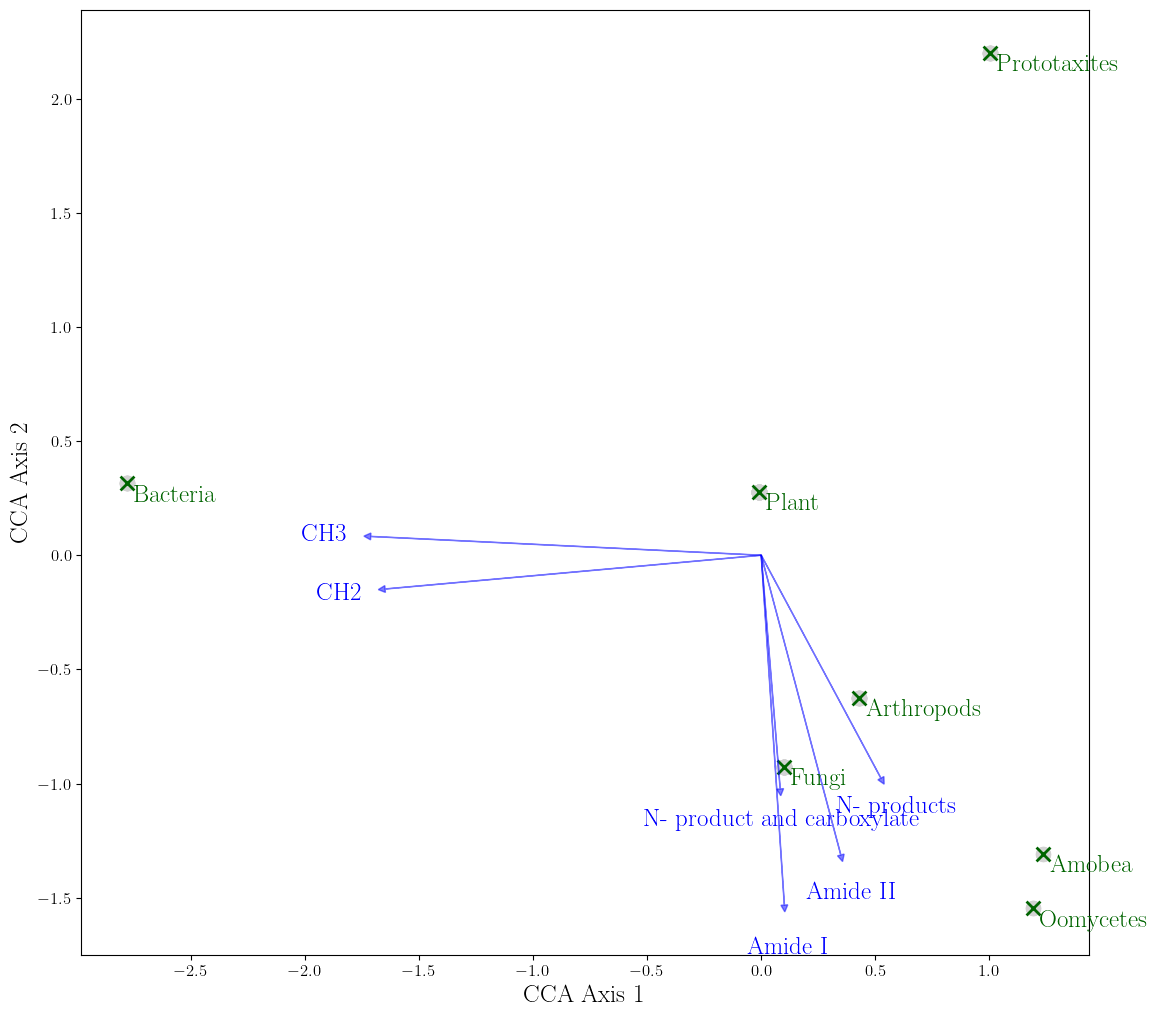

In [28]:




plt.rcParams["figure.figsize"] = (13,13)

#Rescale the arrows for visualisation in the plotting
arrow_scale = 3


#Get the names of the species and the environmental variables
species_names = y.columns.tolist()

env_name = x.columns.tolist()


#Run all the plotting
fig, ax = plt.subplots()

plt.scatter(site_scores_py.iloc[:, 0],  # X-coordinates (first column, CCA1)
            site_scores_py.iloc[:, 1],  # Y-coordinates (second column, CCA2)
            color='lightgray',
            marker='o',
            label='Sites', s=100)


plt.scatter(species_scores_py.iloc[:, 0],  # X-coordinates (first column, CCA1)
            species_scores_py.iloc[:, 1],  # Y-coordinates (second column, CCA2)
            color='darkgreen',
            marker='x',
            label='Species', s=100, linewidth=2,)


for i, j in enumerate(species_scores_py.index): # Corrected loop
    plt.text(species_scores_py.iloc[i, 0] + 0.03, # Corrected access to coordinates
             species_scores_py.iloc[i, 1] - 0.1, # Corrected access to coordinates
             species_names[j], # Use species_name from enumerate
             fontsize=18, color='darkgreen', ha='left', va='bottom', weight ='bold')


#plt.scatter(predicted_scores['V1'],  # X-coordinates (first column, CCA1)
#            predicted_scores['V2'],  # Y-coordinates (second column, CCA2)
#            color='red',
 #           marker="^",
#            label='Predictions', s=100, alpha=0.6)


#for i, j in enumerate(predicted_scores.index):
#    plt.text(predicted_scores.iloc[i, 0] + 0.05, predicted_scores.iloc[i, 1] - 0.1,
#             predict_labels[i], fontsize=15, color='black', ha='left', va='bottom', weight ='bold')


# Plot Environmental Biplot Arrows
# The scores represent the endpoint of the arrow from the origin (0,0)
for i in range(6):
    plt.arrow(0, 0, # Start at origin
              arrow_scale*env_scores_py.iloc[i, 0], # End X
              arrow_scale*env_scores_py.iloc[i, 1], # End Y
              color='blue',
              head_width=0.03, # Adjust arrow head size as needed
              head_length=0.03,
              length_includes_head=True,
              alpha=0.5)
    # Add label for environmental variable
    plt.text(arrow_scale*env_scores_py.iloc[i, 0] * 1.1, # Position label slightly beyond arrow head
             arrow_scale*env_scores_py.iloc[i, 1] * 1.1,
             env_name[i],
             color='blue',
             fontsize=18,
            ha='center', va='center')




ax.tick_params(axis='both', which='major', labelsize=12)
#plt.grid(False, linestyle='--', color='gray', linewidth=0.7, alpha=0.5)
#plt.legend(fontsize=18, frameon=True, edgecolor='black', facecolor='white')
plt.xlabel("CCA Axis 1", fontsize=18)
plt.ylabel("CCA Axis 2", fontsize=18)
ax.set_aspect('equal', adjustable='box')
#plt.savefig('Prototaxites_draft_plot_python_2.svg', dpi = 1000)

plt.show()


You can also test the signfincance of the results using the Anova method which can be called from the Vegan package in R.

In [25]:
# Overall test for the significance of the entire constrained model
print("--- Overall CCA significance test ---")
anova_overall = vegan.anova_cca(cca_results,  permutations=1000)
print(anova_overall)

# Test for significance of each constrained axis
print("\n--- Significance test for each constrained axis  ---")
anova_by_axis = vegan.anova_cca(cca_results, by="axis" , permutations=1000)
print(anova_by_axis)

# Test for significance of each environmental term (variable)
print("\n--- Significance test for each environmental feature ---")
# Note: 'by="terms"' assesses terms sequentially, so order matters.
# 'permutations' argument is good practice for reproducibility
anova_by_terms = vegan.anova_cca(cca_results, by="terms", permutations=1000)
print(anova_by_terms)

# You can also get marginal effects (Type III ANOVA-like)
print("\n--- Significance test for marginal effects of each environmental feature ---")
anova_by_margin = vegan.anova_cca(cca_results, by="margin", permutations=1000)
print(anova_by_margin)

--- Overall CCA significance test ---
Permutation test for cca under reduced model
Permutation: free
Number of permutations: 1000

Model: cca(formula = py_y_matrix ~ `N- products` + `Amide II` + `N- product and carboxylate` + `Amide I` + CH2 + CH3, data = list(`N- products` = c(-0.751266692024174, 0.0618816347666974, -0.0457867025226964, 0.2814399427177, -0.317589809242098, -0.898447348458771, -0.556545938518001, -0.935821318526308, -0.128759318899529, -0.690954068214408, -0.125155078550128, -0.848871523041699, -0.765399986357241, -0.980949411234431, -1.11775703057086, -1.24622984409929, 0.877007287860365, 0.856232846957569, -0.614147038916759, 
-0.830743528988046, -0.699739404066073, -0.619653517228344, -0.680842171678589, -0.621338833317647, 0.784081294777895, 1.272981480506, 0.648446722184817, 0.948015828632936, 0.597478425206831, 1.29458189315553, -1.23702651648488, 3.00674623580217, -0.0174700549628201, -0.707089718297143, -0.76198763843385, -0.772199652757153, -0.744708976944014,